# Library

In [1]:
!pip install torchsummary torchviz pillow

# Data Handling and Processing
import os
import shutil
import numpy as np
import pandas as pd
import cv2
from PIL import Image, ImageOps
from PIL import Image as PILImage  # Untuk manipulasi gambar
from IPython.display import Image as IPImage  # Untuk menampilkan gambar di notebook

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split

# Torchvision for Data Transformations
from torchvision import transforms

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from graphviz import Digraph

# Model Visualization
from torchsummary import summary
from torchviz import make_dot
from IPython.display import Image

# Regular Expressions and Utilities
import re
import math
from collections import defaultdict

In [2]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, 
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
    
    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample:
            identity = self.downsample(x)
        
        out += identity
        out = self.relu(out)
        
        return out

class CNN(nn.Module):
    def __init__(self, num_classes=26):
        super(CNN, self).__init__()
        self.in_channels = 64
        
        self.conv = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock(self.in_channels, out_channels))
        
        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)  # 64
        x = self.layer2(x)  # 128
        x = self.layer3(x)  # 256
        x = self.layer4(x)  # 512
        
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        
        return x

---

# Input 

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CNN()
model.load_state_dict(torch.load("model.pth"))
model.to(device)
model.eval()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_26712\2345396278.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("model.pth"))


CNN(
  (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [4]:
def visualize(images, titles, figsize=(10, 5)):
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray')
        plt.title(title)
        plt.axis('off')
    plt.show()
    
def segment_characters(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    kernel = np.ones((2, 2), np.uint8)

    visualize([gray, binary], ["Grayscale", "Result"])

    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

    bounding_boxes = []
    for i in range(1, num_labels): 
        x, y, w, h, area = stats[i]
        if not (w < 20 and h < 20):
            bounding_boxes.append((x, y, w, h)) 

    line_threshold = 30
    lines = []
    for box in sorted(bounding_boxes, key=lambda b: b[1]): 
        placed = False
        for line in lines:
            if abs(line[-1][1] - box[1]) < line_threshold:
                line.append(box)
                placed = True
                break
        if not placed:
            lines.append([box])  

    for line in lines:
        line.sort(key=lambda b: b[0]) 

    if os.path.exists('chars'):
        shutil.rmtree('chars')

    os.makedirs('chars')

    characters = []
    space_threshold = 30
    
    for idx, line in enumerate(lines):
        previous_x = None
        word_idx = 0  
        for jdx, (x, y, w, h) in enumerate(line):
            if previous_x is not None and (x - previous_x) > space_threshold:
                word_idx += 1  
            previous_x = x + w 

            char = binary[y:y + h, x:x + w]
            characters.append(char)
            
            cv2.imwrite(f'chars/char_{idx}_{word_idx}_{jdx}.png', 255 - char)

    return characters

In [6]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'([0-9]+)', s)]

class PadToSquareTransform:
    def __init__(self, fill=0):
        self.fill = fill

    def __call__(self, img):
        return pad_to_square(img, fill=self.fill)

def pad_to_square(img, padding_mode='constant', fill='white', pad_ratio=0.15):
    """
    Menambahkan padding ke gambar sehingga menjadi persegi dengan warna padding putih,
    dan menambahkan padding tambahan sebesar pad_ratio di sekitarnya.
    """
    width, height = img.size
    max_side = max(width, height)
    
    padding_left = (max_side - width) // 2
    padding_right = max_side - width - padding_left
    padding_top = (max_side - height) // 2
    padding_bottom = max_side - height - padding_top

    # Apply initial padding to make square
    img_padded = ImageOps.expand(
        img, 
        border=(padding_left, padding_top, padding_right, padding_bottom), 
        fill=fill
    )
    
    # Add additional 15% padding around the square
    additional_padding = int(max_side * pad_ratio)
    img_padded = ImageOps.expand(
        img_padded, 
        border=(additional_padding, additional_padding, additional_padding, additional_padding), 
        fill=fill
    )
    
    return img_padded


def predict_image(model, image_path, processed_images_folder="processed_images"):
    # Membaca gambar dan preprocessing
    image = PILImage.open(image_path).convert('L')  # Menggunakan PILImage.open
    image = ImageOps.invert(image)  # Menggunakan ImageOps dari PIL
    img_array = np.array(image)
    kernel = np.ones((2, 2), np.uint8)
    img_array = cv2.dilate(img_array, kernel, iterations=1)
    image = PILImage.fromarray(img_array)  # Menggunakan PILImage.fromarray
    
    # Transformasi
    transform = transforms.Compose([
        PadToSquareTransform(fill=0),
        transforms.Grayscale(num_output_channels=1),  
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    processed_image = transform(image).unsqueeze(0).to(device)
    
    # Menyimpan gambar yang telah diproses (termasuk padding dan dilatasi)
    if not os.path.exists(processed_images_folder):
        os.makedirs(processed_images_folder)
    processed_image_pil = transforms.ToPILImage()(processed_image.squeeze(0).cpu())
    processed_image_pil.save(os.path.join(processed_images_folder, os.path.basename(image_path)))
    
    # Prediksi menggunakan model
    model.eval()
    with torch.no_grad():
        output = model(processed_image)
        _, predicted = torch.max(output, 1)
        return chr(65 + predicted.item())

def predict_folder(model, folder_path, processed_images_folder="processed_images"):
    results = []
    image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    for filename in image_files:
        image_path = os.path.join(folder_path, filename)
        prediction = predict_image(model, image_path, processed_images_folder)
        results.append((filename, prediction))
    return results

def display_sorted_predictions(predictions, processed_images_folder="processed_images"):
    sorted_predictions = sorted(predictions, key=lambda x: natural_sort_key(x[0]))
    lines = defaultdict(lambda: defaultdict(list))
    
    for filename, pred in sorted_predictions:
        match = re.match(r'char_(\d+)_(\d+)_(\d+)\.png', filename)
        if match:
            line_idx = int(match.group(1))
            word_idx = int(match.group(2))
            char_idx = int(match.group(3))
            lines[line_idx][word_idx].append((char_idx, filename, pred))

    result = ''
    for line_idx in sorted(lines.keys()):
        for word_idx in sorted(lines[line_idx].keys()):
            chars = sorted(lines[line_idx][word_idx], key=lambda x: x[0])
            word_text = ''.join(pred for _, _, pred in chars)
            result += word_text + ' '  # Tambahkan spasi antar kata
        result = result.strip() + '\n'  # Hapus spasi di akhir baris dan tambahkan newline
    print(result)
    
    return result

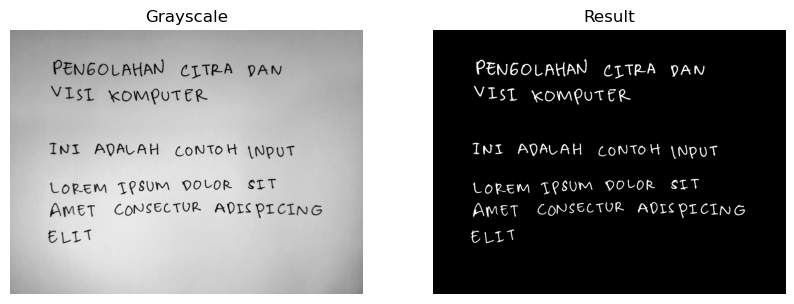

PENGOLAHAN CITRA DAN
VISI KDMPUTYMR
INI ADALAH CONTOH LNPUT
LOREM IPSUM DOLOR SIT
AMET CONSECTUR ADISPICING
ELIT



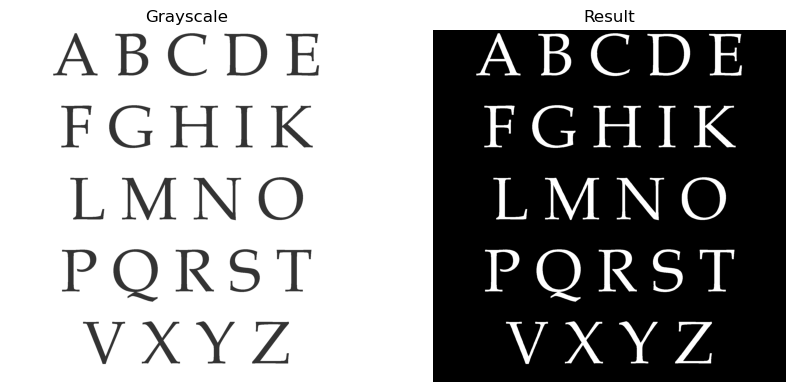

A B C D H
E G H I K
L M N O
P Q R S I
V X Y L



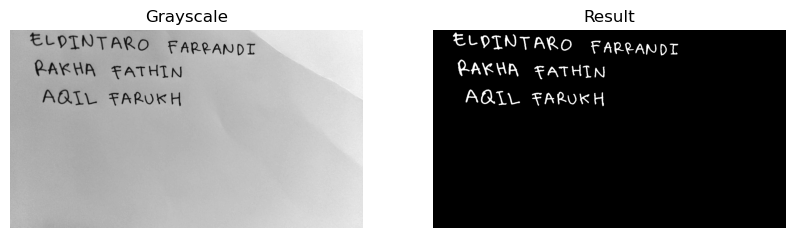

ELDINTARO FARRANDI
RAKHA FATHIN
AQIL FARUKH



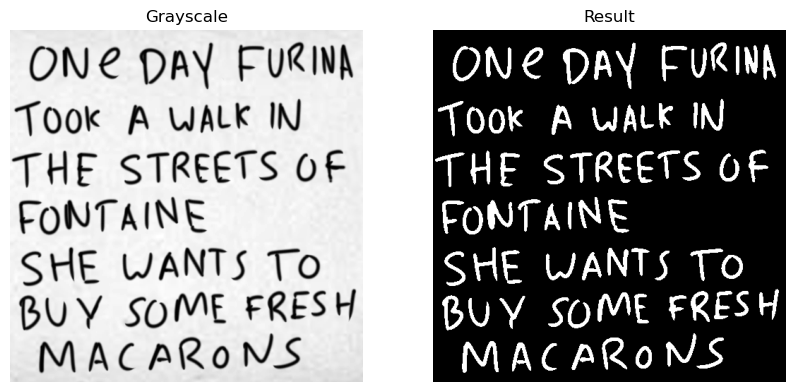

ONRDAY FURWNA
TOOK AWALKWN
THE STREETSOF
EONTAWNE
SHE WANTSTO
BUY SOMEFRESH
MACARONS



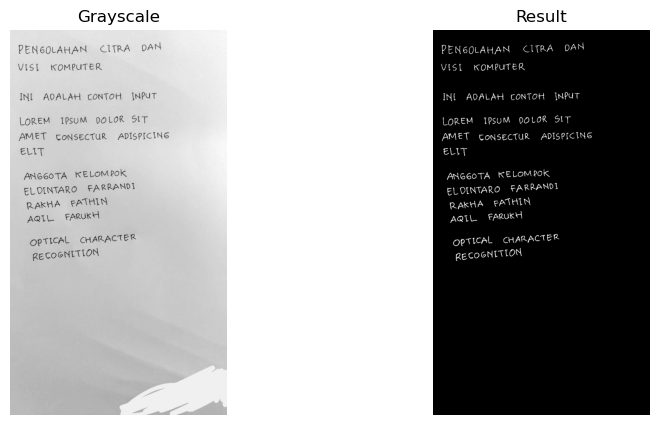

PENGOLAHAN CITRA DAN
VLSI KOMPUTER
INI ADALAH CONTOH INPUT
LOREM IPSUM DOLOR SIT
AMET CONSECTUR ADISPICING
ELIT
ANGGOTA KELOMDOK
ELDINTARO FARRANDI
RAKHA FAKHIN
AQIL FARUKH
OPTICAL CHARACTER
RECOGNITION



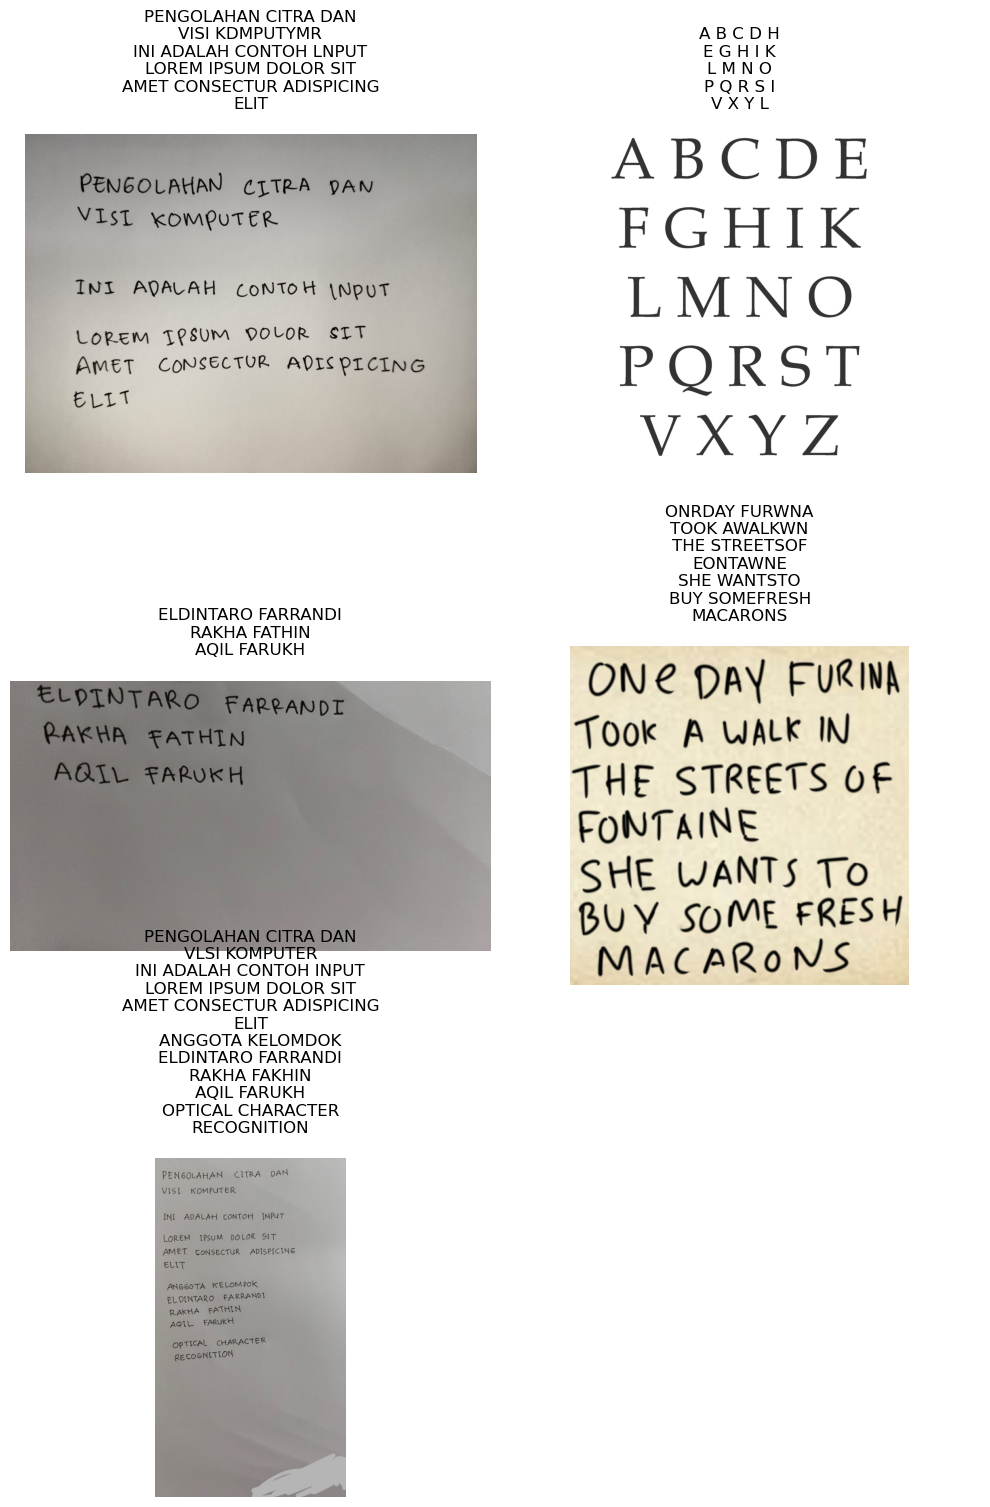

In [16]:
image_paths = [
    "image/tulisan1.jpg",
    'image/tulisan2.jpg',
    "image/tulisan3.jpg",
    "image/tulisan4.png",
    "image/tulisan5.jpg",
]

results = []
images = []

for image_path in image_paths:
    ch = segment_characters(image_path)
    predictions = predict_folder(model, "chars")
    result = display_sorted_predictions(predictions)
    results.append(result)
    
    img = PILImage.open(image_path)
    images.append(img)

# Create a figure to display images and their results
n_images = len(images)
n_cols = 2
n_rows = math.ceil(n_images / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))

axes = np.array(axes).flatten()  # Convert to NumPy array

for idx, ax in enumerate(axes):
    if idx < n_images:
        ax.imshow(images[idx])
        ax.axis('off')
        ax.set_title(f'{results[idx]}', fontsize=12)
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()